# Sprint 11 - Proyecto modulo 2 - EMPRESA PRODUCTOS ALIMENTICIOS - Carlos Ortiz

# Introducción

En el competitivo mundo de las aplicaciones móviles de productos alimenticios, comprender el comportamiento del usuario es clave para mejorar la experiencia del cliente y aumentar la conversión. Este proyecto analiza los registros de eventos de usuarios dentro de la aplicación de una empresa emergente, con el fin de identificar patrones de uso, puntos de abandono en el embudo de ventas y el impacto de cambios en el diseño de la interfaz. Mediante el análisis de datos y la validación de experimentos tipo A/A/B, se busca tomar decisiones informadas sobre la evolución del producto.

# Objetivo general
Analizar el comportamiento de los usuarios en la aplicación para identificar oportunidades de mejora en el embudo de ventas y evaluar el impacto del rediseño tipográfico a través de un experimento A/A/B.


# Objetivos específicos

1. Estudiar las etapas del embudo de ventas y determinar en cuáles se produce la mayor pérdida de usuarios.

2. Evaluar la calidad y distribución de los datos recopilados, asegurando su validez para el análisis.

3. Comparar estadísticamente los grupos experimentales A/A/B para identificar si el nuevo diseño afecta el comportamiento de los usuarios.

# Desarrollo del proyecto

In [1]:
# Importar librerias 
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest



## Abrir el archivo de datos y leer la información genera

In [2]:
data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


##  Preparar los datos para el análisis

In [4]:
data['EventTimestamp'] = pd.to_datetime(data['EventTimestamp'],unit='s')
data['date'] = data['EventTimestamp'].dt.normalize()
data['hour'] = data['EventTimestamp'].dt.time.astype(str)

data

,EventName,DeviceIDHash,EventTimestamp,ExpId,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       244126 non-null  object        
 1   DeviceIDHash    244126 non-null  int64         
 2   EventTimestamp  244126 non-null  datetime64[ns]
 3   ExpId           244126 non-null  int64         
 4   date            244126 non-null  datetime64[ns]
 5   hour            244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


Se verificaron los datos cargados y, al revisar el tipo de dato correspondiente a la fecha de los eventos, se evidenció que venían en formato Unix timestamp (es decir, los segundos transcurridos desde el 1 de enero de 1970). Se realizó la conversión al formato datetime y, posteriormente, se separaron las fechas y las horas en columnas distintas para facilitar el análisis temporal. Como observación adicional, no se encontraron valores faltantes en el conjunto de datos.

## Estudiar y comprobar los datos

### ¿Cuántos eventos hay en los registros?

In [6]:
print(data['EventName'].nunique())
print(data['EventName'].unique())


5
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


Hay 5 eventos dentro de los datos, dentro de los cuales estan 'MainScreenAppear', 'PaymentScreenSuccessful' 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial'.

### ¿Cuántos usuarios hay en los registros?

In [7]:
users= data['DeviceIDHash'].nunique()
users

7551

El conjunto de datos incluye información de 7.551 usuarios únicos que interactuaron con la aplicación durante el periodo analizado. Esta cifra representa la base total de usuarios sobre la cual se calcularán las métricas de comportamiento y conversión.

### ¿Cuál es el promedio de eventos por usuario?

In [8]:
mean_users= data.groupby(['DeviceIDHash'])['EventName'].count().mean()
mean_users.round(3)

32.33

El promedio de eventos registrados por usuario es de 32,33. Esto indica que, en promedio, cada usuario realizó más de treinta acciones dentro de la aplicación durante el periodo analizado, lo que sugiere un nivel de interacción relativamente alto con la plataforma.

### ¿Qué periodo de tiempo cubren los datos?

In [9]:
print(data['EventTimestamp'].min())
print(data['EventTimestamp'].max())
print(data['EventTimestamp'].max()-data['EventTimestamp'].min())

2019-07-25 04:43:36
2019-08-07 21:15:17
13 days 16:31:41


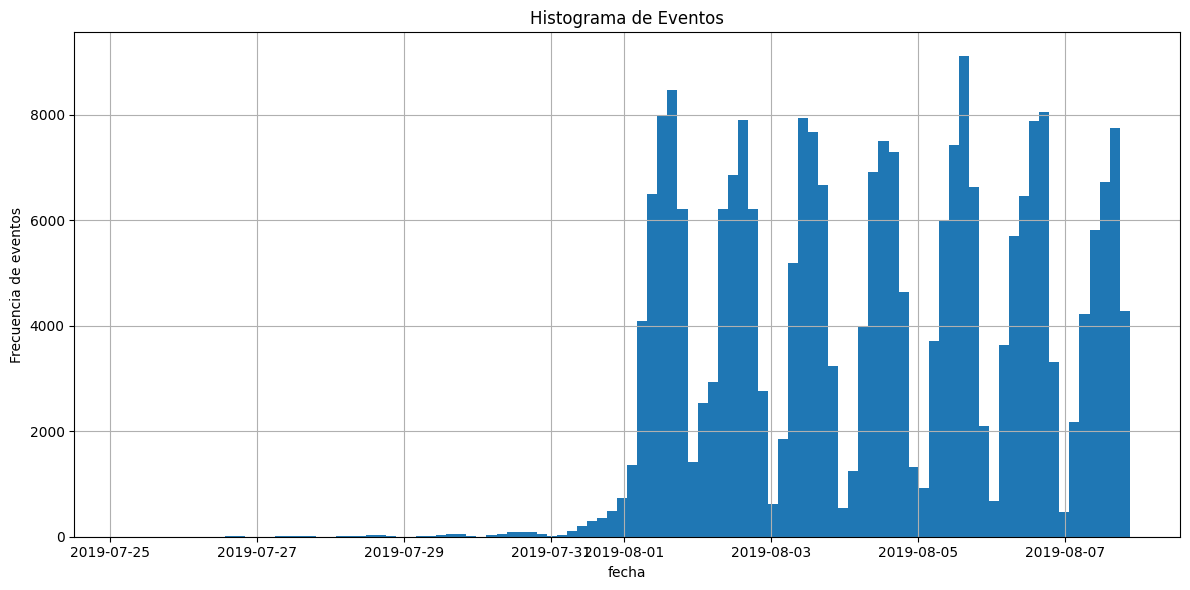

In [10]:
plt.figure(figsize=(12,6))
plt.hist(data['EventTimestamp'],bins=100)
plt.title('Histograma de Eventos')
plt.xlabel('fecha')
plt.ylabel('Frecuencia de eventos')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
data_no=data[data['date'] < '2019-07-31']
data=data.drop(data_no.index)

data

,EventName,DeviceIDHash,EventTimestamp,ExpId,date,hour
797,MainScreenAppear,3670880358399219515,2019-07-31 01:11:46,247,2019-07-31,01:11:46
798,OffersScreenAppear,3799109751993694887,2019-07-31 01:21:04,248,2019-07-31,01:21:04
799,Tutorial,1126021718529336913,2019-07-31 01:32:11,247,2019-07-31,01:32:11
800,MainScreenAppear,4293428370257583636,2019-07-31 02:19:18,248,2019-07-31,02:19:18
801,MainScreenAppear,4567464647598975872,2019-07-31 02:33:30,247,2019-07-31,02:33:30
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


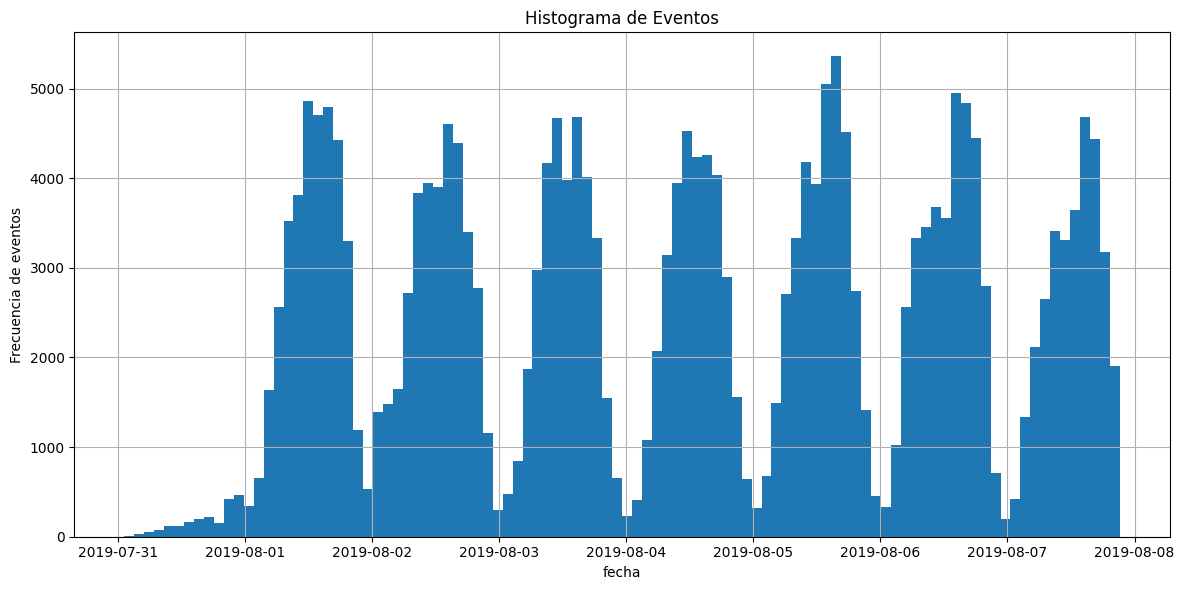

In [12]:
plt.figure(figsize=(12,6))
plt.hist(data['EventTimestamp'],bins=100)
plt.title('Histograma de Eventos')
plt.xlabel('fecha')
plt.ylabel('Frecuencia de eventos')
plt.grid(True)
plt.tight_layout()
plt.show()

Los datos abarcan desde el 25 de julio de 2019 a las 04:43 hasta el 7 de agosto de 2019 a las 21:15, lo que corresponde a un periodo total de 13 días, 16 horas y 32 minutos. Este rango temporal servirá como base para el análisis del comportamiento de los usuarios en la aplicación.

Sin embargo, se identificó que la frecuencia de eventos antes del 31 de julio es baja, lo que sugiere que esos registros podrían corresponder a pruebas internas o a una fase incompleta de recolección de datos. Por lo tanto, se sugiere excluir los datos anteriores al 31 de julio de 2019 para asegurar la calidad y representatividad del análisis.

### ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [13]:
len(data_no)

797

Se eliminaron 797 registros, lo que representa aproximadamente el 0,33 % del total original de 244.126 eventos. Esta proporción es mínima y no afecta la validez del análisis posterior.

###  Usuarios de los tres grupos experimentales

In [14]:
n_g=data.groupby('ExpId')['DeviceIDHash'].nunique()
n_g

ExpId
246    2485
247    2517
248    2540
Name: DeviceIDHash, dtype: int64

In [15]:
g246= data[data['ExpId']==246]
g247= data[data['ExpId']==247]
g248= data[data['ExpId']==248]

In [16]:
upg = data.groupby('DeviceIDHash')['ExpId'].nunique()
u_rep = upg[upg > 1]
u_rep.shape[0]

0

Se confirmó la presencia de registros en los tres grupos experimentales definidos en el test A/A/B:

- Grupo 246 (control A)
- Grupo 247 (control A)
- Grupo 248 (grupo de prueba B)

La cantidad de usuarios en cada grupo varía mínimamente, lo que indica una asignación equilibrada. Además, se verificó que no existen usuarios presentes en más de un grupo experimental, lo que garantiza la validez del diseño del experimento y evita sesgos por exposición cruzada.

## Estudiar el embudo de eventos

### Eventos y sus frecuencias

In [17]:
# Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
data['EventName'].value_counts()

MainScreenAppear           118681
OffersScreenAppear          46724
CartScreenAppear            42623
PaymentScreenSuccessful     34253
Tutorial                     1048
Name: EventName, dtype: int64

### Cantidad de usuarios por eventos

In [18]:
ca = data.groupby(['EventName'])['DeviceIDHash'].nunique().reset_index()
ca.columns=('event','n_users')
ca= ca.sort_values(by='n_users',ascending=False)

In [19]:
total_users=data['DeviceIDHash'].nunique()
ca['proporcion'] = ((ca['n_users']/total_users)*100).round(2)
ca

,event,n_users,proporcion
1,MainScreenAppear,7429,98.50
2,OffersScreenAppear,4606,61.07
0,CartScreenAppear,3742,49.62
3,PaymentScreenSuccessful,3542,46.96
4,Tutorial,845,11.20


### Orden de los Eventos 

In [20]:
# Identificar la frecuencia con que Tutorial se encuentra en primer lugar

t=data[data['EventName']=='Tutorial']
t1=t['DeviceIDHash'].unique()
print('Usuarios que vieron el Tutorial',len(t1))
q = data[data['DeviceIDHash'].isin(t1)]
q= q.sort_values(by=['DeviceIDHash','EventTimestamp'])
primer_evento = q.groupby('DeviceIDHash').first().reset_index()
print('Usuarios que vieron en primer lugar el Tutorial',primer_evento[primer_evento['EventName']=='Tutorial'].shape[0])


Usuarios que vieron el Tutorial 845
Usuarios que vieron en primer lugar el Tutorial 789


**¿En qué orden crees que ocurrieron las acciones?**

Se identificó que las acciones más frecuentes siguen un patrón lógico en el recorrido del usuario dentro de la aplicación, ocurriendo en el siguiente orden:
1. Tutorial
2. MainScreenAppear
3. OffersScreenAppear
4. CartScreenAppear
5. PaymentScreenSuccessful


Este orden sugiere un flujo consistente desde la pantalla principal hasta la confirmación de pago, lo cual es coherente con un embudo de conversión típico.

De los 845 usuarios que accedieron al evento `Tutorial`, 789 lo hicieron como su primer evento, lo que representa aproximadamente el 93,37 %. Esto indica que, en la mayoría de los casos, el tutorial aparece al inicio del recorrido del usuario, aunque existe una minoría (6,63 %) que lo visualizó en etapas posteriores.





###  Embudo de eventos

In [21]:
serie=ca['event']
eventos= serie.tolist()
eventos.remove('Tutorial')
eventos
ca=ca.drop(index=[4])

In [22]:
ca['n_ret'] = (ca['n_users'].shift(1) - ca['n_users'] ).round(2)
ca['%_ret'] = (ca['n_users'] / ca['n_users'].shift(1) * 100).round(2)
ca.loc[ca.index[0], '%_ret'] = 100.0
ca['%_ret_cum'] = (ca['n_users'] / ca['n_users'].iloc[0] * 100).round(2)
ca

,event,n_users,proporcion,n_ret,%_ret,%_ret_cum
1,MainScreenAppear,7429,98.50,NaN,100.00,100.00
2,OffersScreenAppear,4606,61.07,2823.0,62.00,62.00
0,CartScreenAppear,3742,49.62,864.0,81.24,50.37
3,PaymentScreenSuccessful,3542,46.96,200.0,94.66,47.68


### ¿En qué etapa pierdes más usuarios?

Se identificó que la mayor pérdida de usuarios ocurre en la primera etapa del embudo, entre los eventos MainScreenAppear y OffersScreenAppear. En esta transición, se observa una reducción de 2.823 usuarios, lo que representa una pérdida del 38 % respecto a quienes iniciaron en el primer evento.

Este comportamiento sugiere que una parte significativa de los usuarios no encuentra un incentivo claro para continuar explorando la aplicación tras el ingreso inicial. Podría estar relacionado con la usabilidad de la pantalla principal, tiempos de carga, falta de ofertas atractivas visibles, o simplemente desinterés.

### ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

Del total de usuarios que iniciaron su recorrido en la aplicación con el evento MainScreenAppear, solo el 47,68 % llegó a completar una compra exitosa PaymentScreenSuccessful. Esto indica que menos de la mitad de los usuarios logran convertir, lo cual representa una oportunidad importante de optimización en las etapas intermedias del embudo

## Estudiar los resultados del experimento

### ¿Cuántos usuarios hay en cada grupo?

In [23]:
print('Registros en el grupo 246:',len(g246))
print('Registros en el grupo 247:',len(g247))
print('Registros en el grupo 248:',len(g248))

Registros en el grupo 246: 80045
Registros en el grupo 247: 77811
Registros en el grupo 248: 85473


In [24]:
# Numero de Usuarios unicos en cada grupo
n_g

ExpId
246    2485
247    2517
248    2540
Name: DeviceIDHash, dtype: int64

La cantidad de usuarios únicos es bastante equilibrada entre los tres grupos, con una diferencia mínima que no representa un riesgo para la validez del experimento. Esto sugiere que la asignación aleatoria se realizó correctamente.

### Test A/A

In [25]:
events_246 = g246.groupby('DeviceIDHash')['EventName'].count()
events_247 = g247.groupby('DeviceIDHash')['EventName'].count()
events_247

DeviceIDHash
6909561520679493         5
7702139951469979       137
28534696657485531       29
28755862496905658        8
29094035245869447       24
                      ... 
9187094690649224379     10
9187990861085277398    231
9196211109317457061      3
9202927726357731300     10
9206002508877262744     81
Name: EventName, Length: 2517, dtype: int64

In [26]:
stat, p = mannwhitneyu(events_246, events_247, alternative='two-sided')
print('p-valor:', "{0:.4f}".format(p))

p-valor: 0.8579


Un p-valor de 0.8579 en la prueba U de Mann-Whitney significa que no hay evidencia estadísticamente significativa de diferencia entre los grupos 246 y 247 respecto al número de veces que los usuarios realizaron ese evento específico.

El comportamiento de los usuarios en los grupos de control no presenta diferencias relevantes en la frecuencia del evento analizado. Esto confirma que la asignación entre grupos fue balanceada y que el experimento A/A se ejecutó correctamente para ese evento.

### Evento más popular

In [27]:
ep = data['EventName'].value_counts().idxmax()
ep

'MainScreenAppear'

El evento más popular fue `MainScreenAppear`

In [28]:
n_246 = g246['EventName'].nunique()
n_247 = g247['EventName'].nunique()
print(n_246)
print(n_247)

5
5


In [29]:
e_246 = data[(data['ExpId'] == 246) & (data['EventName'] == ep)]['DeviceIDHash'].nunique()
e_247 = data[(data['ExpId'] == 247) & (data['EventName'] == ep)]['DeviceIDHash'].nunique()
print(e_246)
print(e_247)

2452
2479


In [30]:
p_246 = e_246 / n_246
p_247 = e_247 / n_247


In [31]:
print('Proporción en grupo 246:',p_246)
print('Proporción en grupo 247:',p_247)

Proporción en grupo 246: 490.4
Proporción en grupo 247: 495.8


In [32]:
def comparar_eventos_mannwhitney(g1, g2, event_col='EventName', user_col='DeviceIDHash', alpha=0.05):
    resultados = []

    eventos = set(g1[event_col].unique()).intersection(g2[event_col].unique())
    
    for evento in eventos:
        
        u1 = g1[g1[event_col] == evento].groupby(user_col).size()
        u2 = g2[g2[event_col] == evento].groupby(user_col).size()
        
        if len(u1) > 0 and len(u2) > 0:
            stat, p = mannwhitneyu(u1, u2, alternative='two-sided')
            resultados.append({
                'event': evento,
                'users_g1': len(u1),
                'users_g2': len(u2),
                'mean_g1': u1.mean(),
                'mean_g2': u2.mean(),
                'p_value': round(p, 4),
                'significativo': p < alpha
            })
    
    return pd.DataFrame(resultados).sort_values('p_value')


#### (g246, g246)

In [33]:
comparar_eventos_mannwhitney(g246, g247)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
0,Tutorial,278,285,1.161871,1.217544,0.3758,False
1,PaymentScreenSuccessful,1200,1159,9.960833,8.697153,0.3945,False
4,CartScreenAppear,1267,1239,11.672455,10.117030,0.4704,False
2,MainScreenAppear,2452,2479,15.535073,15.954014,0.6055,False
3,OffersScreenAppear,1544,1526,9.642487,10.025557,0.7563,False


- Todos los valores p son mayores que 0.05, lo que indica que no hay diferencias estadísticamente significativas entre los grupos 246 y 247 para ninguno de los eventos analizados.

- Las medias son similares entre ambos grupos, lo cual refuerza que los usuarios de los dos grupos se comportan de manera comparable.

- El campo significativo es False para todos los eventos, lo que respalda que la diferencia entre los grupos podría deberse al azar.

### Test A/B

#### (g246, g248)

In [34]:
comparar_eventos_mannwhitney(g246, g248)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
2,MainScreenAppear,2452,2498,15.535073,16.428743,0.1034,False
4,CartScreenAppear,1267,1236,11.672455,12.377832,0.1138,False
0,Tutorial,278,282,1.161871,1.340426,0.1474,False
1,PaymentScreenSuccessful,1200,1183,9.960833,10.329670,0.6234,False
3,OffersScreenAppear,1544,1536,9.642487,10.766276,0.7034,False


Grupo 246 / Grupo 248
Ningún evento tiene diferencias estadísticamente significativas (p_value > 0.05 en todos los casos).
- No hay evidencia de que el nuevo diseño haya cambiado el comportamiento comparado con este grupo.

#### (g247, g248)

In [35]:
comparar_eventos_mannwhitney(g247, g248)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
4,CartScreenAppear,1239,1236,10.117030,12.377832,0.0193,True
1,PaymentScreenSuccessful,1159,1183,8.697153,10.329670,0.1697,False
2,MainScreenAppear,2479,2498,15.954014,16.428743,0.2739,False
0,Tutorial,285,282,1.217544,1.340426,0.5657,False
3,OffersScreenAppear,1526,1536,10.025557,10.766276,0.9510,False


Solo CartScreenAppear presenta una diferencia estadísticamente significativa (p = 0.0193). En este caso, los usuarios del grupo 248 usaron el carrito más veces en promedio (12.37 vs 10.11).
- Hay una diferencia puntual en ese evento. Puede ser real o aleatoria.



#### (g246yg247, g248)

In [36]:
g246yg247 =pd.concat([g246,g247])

In [37]:
comparar_eventos_mannwhitney(g246yg247, g248)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
4,CartScreenAppear,2506,1236,10.903432,12.377832,0.0239,True
2,MainScreenAppear,4931,2498,15.745691,16.428743,0.1158,False
0,Tutorial,563,282,1.190053,1.340426,0.2404,False
1,PaymentScreenSuccessful,2359,1183,9.339975,10.329670,0.2846,False
3,OffersScreenAppear,3070,1536,9.832899,10.766276,0.7978,False


#### Nivel de significancia 

El nivel de significancia (alpha) fue 0.05, que es el valor más comúnmente aceptado en estudios estadísticos. Esto significa que:

- Aceptas un 5% de probabilidad de cometer un error tipo I (falso positivo), es decir, concluir que existe una diferencia cuando en realidad no la hay.

#### Cantidad de pruebas hipótesis

Se realizaron 20 pruebas hipotesis, 5 por cada comparacion entre grupos 
- 246/247
- 246/248
- 247/248
- g246 y g247 / g248

#### ¿Qué nivel de significancia debería usar?



In [38]:
alpha=0.05
alpha_bonferroni= alpha /20
alpha_bonferroni

0.0025

Esto significa que, para considerar un resultado como significativo, el p_value debería ser menor a 0.0025

#### Cambio del alpha 
alpha=0.0025

In [39]:
def comparar_eventos_mannwhitney(g1, g2, event_col='EventName', user_col='DeviceIDHash', alpha=0.0025):
    resultados = []

    eventos = set(g1[event_col].unique()).intersection(g2[event_col].unique())
    
    for evento in eventos:
        
        u1 = g1[g1[event_col] == evento].groupby(user_col).size()
        u2 = g2[g2[event_col] == evento].groupby(user_col).size()
        
        if len(u1) > 0 and len(u2) > 0:
            stat, p = mannwhitneyu(u1, u2, alternative='two-sided')
            resultados.append({
                'event': evento,
                'users_g1': len(u1),
                'users_g2': len(u2),
                'mean_g1': u1.mean(),
                'mean_g2': u2.mean(),
                'p_value': round(p, 4),
                'significativo': p < alpha
            })
    
    return pd.DataFrame(resultados).sort_values('p_value')


In [40]:
#(g246, g247)
comparar_eventos_mannwhitney(g246, g247)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
0,Tutorial,278,285,1.161871,1.217544,0.3758,False
1,PaymentScreenSuccessful,1200,1159,9.960833,8.697153,0.3945,False
4,CartScreenAppear,1267,1239,11.672455,10.117030,0.4704,False
2,MainScreenAppear,2452,2479,15.535073,15.954014,0.6055,False
3,OffersScreenAppear,1544,1526,9.642487,10.025557,0.7563,False


In [41]:
#(g246, g248)
comparar_eventos_mannwhitney(g246, g248)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
2,MainScreenAppear,2452,2498,15.535073,16.428743,0.1034,False
4,CartScreenAppear,1267,1236,11.672455,12.377832,0.1138,False
0,Tutorial,278,282,1.161871,1.340426,0.1474,False
1,PaymentScreenSuccessful,1200,1183,9.960833,10.329670,0.6234,False
3,OffersScreenAppear,1544,1536,9.642487,10.766276,0.7034,False


In [42]:
#(g247, g248)
comparar_eventos_mannwhitney(g247, g248)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
4,CartScreenAppear,1239,1236,10.117030,12.377832,0.0193,False
1,PaymentScreenSuccessful,1159,1183,8.697153,10.329670,0.1697,False
2,MainScreenAppear,2479,2498,15.954014,16.428743,0.2739,False
0,Tutorial,285,282,1.217544,1.340426,0.5657,False
3,OffersScreenAppear,1526,1536,10.025557,10.766276,0.9510,False


In [43]:
#(g246 y g247 , g248)
comparar_eventos_mannwhitney(g246yg247, g247)

,event,users_g1,users_g2,mean_g1,mean_g2,p_value,significativo
0,Tutorial,563,285,1.190053,1.217544,0.6181,False
1,PaymentScreenSuccessful,2359,1159,9.339975,8.697153,0.6189,False
4,CartScreenAppear,2506,1239,10.903432,10.117030,0.6746,False
2,MainScreenAppear,4931,2479,15.745691,15.954014,0.7664,False
3,OffersScreenAppear,3070,1526,9.832899,10.025557,0.8572,False


Esto refuerza la hipótesis nula: los grupos no muestran diferencias relevantes en el comportamiento de los usuarios debido al cambio de fuente.

podemos afirmar que el cambio de fuente no impactó negativamente el comportamiento del usuario, y no hay evidencia estadística de que haya alterado significativamente las interacciones dentro de la app.

# Conclusiones

Se analizó el comportamiento de los usuarios en la aplicación de la empresa emergente de productos alimenticios durante el período comprendido entre el 31 de julio y el 7 de agosto de 2019. A partir del estudio del embudo de ventas, se identificó que la mayor pérdida de usuarios ocurre entre la visualización de la pantalla principal y la sección de ofertas. Solo el 47,68% de los usuarios completan el proceso hasta la etapa de pago.

En cuanto a la prueba A/A/B, se confirmó que los dos grupos de control (246 y 247) no presentan diferencias estadísticamente significativas entre sí, lo que valida la correcta aleatorización de los usuarios. Posteriormente, se comparó el grupo experimental (248), al cual se le asignó una nueva fuente tipográfica, con ambos grupos de control. Aunque en una de las comparaciones se detectó una diferencia puntual en el evento de carrito de compras, esta no se mantuvo significativa tras aplicar la corrección de Bonferroni para múltiples pruebas.

En conclusión, no se encontraron diferencias significativas entre los grupos, lo que sugiere que el cambio de fuente no afecta negativamente el comportamiento del usuario. Por tanto, el rediseño puede implementarse con confianza, sin riesgo de impacto adverso en la experiencia de usuario ni en la conversión.

**Todo un Éxito**